# Transform Photos to Monet Paintings with CycleGANs


Artists like Claude Monet are recognized for the unique styles of their works, such as the unique colour scheme and brush strokes. These are hard to be imitated by normal people, and even for professional painters, it will not be easy to produce a painting whose style is Monet-esque. However, thanks to the invention of Generative Adversarial Networks (GANs) and their many variations, Data Scientists and Machine Learning Engineers can build and train deep learning models to bring an artist's peculiar style to your photos. 



<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0KSEEN/images/starry_night.png" width="60%">


## Table of Contents

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining Helper Functions">Defining Helper Functions</a></li>
        </ol>       
    </li>
    <li><a href="#What is Image Style Transfer in Deep Learning?">What is Image Style Transfer in Deep Learning?</a></li>
    <li><a href="#CycleGANs">CycleGANs</a>
        <ol>
            <li><a href="#A quick recap on vanilla GANs">A quick recap on vanilla GANs</a></li>
            <li><a href="#What's novel about CycleGANs?">What's novel about CycleGANs?</a></li>
        </ol>  
    </li>   
    <li><a href="#Data Loading">Data Loading</a></li>
    <li><a href="#Building the Generator">Building the Generator</a>
        <ol>
            <li><a href="#Defining the Downsampling Block">Defining the Downsampling Block</a></li>
            <li><a href="#Defining the Upsampling Block">Defining the Upsampling Block</a></li>
            <li><a href="#Assembling the Generator">Assembling the Generator</a></li>
        </ol>  
    </li>   
    <li><a href="#Building the Discriminator">Building the Discriminator</a></li>
    <li><a href="#Building the CycleGAN Model">Building the CycleGAN Model</a>
    <li><a href="#Defining Loss Functions">Defining Loss Functions</a> 
    <li><a href="#Model Training">Model Training</a>  
         <ol>
            <li><a href="#Training the CycleGAN">Training the CycleGAN</a></li>
        </ol>  
    </li>     
    <li><a href="#Visualize our Monet-esque photos">Visualize our Monet-esque photos</a>
        <ol>
            <li><a href="#Loading the Pre-trained Weights">Loading the Pre-trained Weights</a></li>
            <li><a href="#Visualizing Style Transfer Output">Visualizing Style Transfer Output</a></li>
        </ol>       
    </li>
</ol>


## Objectives

In this project I am going to:

*   Describe the novelty about CycleGANs
*   Define Cycle Consistency Loss
*   Describe the complicated architecture of a CycleGAN
*   Practice the training deep learning models
*   Implement a pre-trained CycleGAN for image style transfer


## Setup

For this project, we will be using the following libraries:

*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`Pillow`](https://pillow.readthedocs.io/en/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for image processing functions.
*   [`tensorflow`](https://www.tensorflow.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and neural network related functions.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Installing Required Libraries



In [1]:
#!pip install --user install -qy numpy==1.22.3 matplotlib==3.5.1 tensorflow==2.9.0 skillsnetwork==0.20.6

In [2]:
# %%capture
#!pip3 install --upgrade tensorflow
#!pip3 install tensorflow_addons
#!pip3 install pydot

### Importing Required Libraries


In [3]:
import warnings
warnings.simplefilter('ignore')

import keras
from tensorflow.keras.utils import plot_model

import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")
import tensorflow_addons as tfa

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2DTranspose,BatchNormalization,ReLU,Conv2D,LeakyReLU


from IPython import display

import skillsnetwork
print(f"skillsnetwork version: {skillsnetwork.__version__}")

import matplotlib.pyplot as plt

%matplotlib inline


import os
from os import listdir
from pathlib import Path
import imghdr

import time
from tqdm.auto import tqdm
import time
from PIL import Image
import random


tensorflow version: 2.15.0
skillsnetwork version: 0.20.6


In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.15.0


### Defining Helper Functions


In [5]:
def decode_image(file_path):
    
    """
    return a decoded tf tensor given an image file path, 
    
    """
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


def load_dataset(directory, labeled=True):
    
    """
    return a tf.data.Dataset consisting of images from directory, decoded by the function decode_image
    
    """
    dataset = tf.data.Dataset.list_files(directory + "/*.jpg")
    dataset = dataset.map(decode_image, num_parallel_calls=AUTOTUNE)
    
    return dataset

## What is Image Style Transfer in Deep learning?

Image Style Transfer can be viewed as an image-to-image translation, where we "translate" image A into a new image by combining the content of image A with the style of another image B (which could be a famous Monet painting).



<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0KSEEN/images/style_transfers.png" width="100%" style="vertical-align:middle;margin:20px 0px"></center>

<p style="color:gray; text-align:center;">

## CycleGANs


### A quick recap on vanilla GANs

GANs are a family of algorithms are use _learning by comparison_. A vanilla GAN has two parts, a Generator network which we denote by $\boldsymbol G$ and a Discriminator network which we denote by $\boldsymbol D$. $\boldsymbol G$ tries to fool $\boldsymbol D$ through continuously improving its own ability to produce images that are fake but close to the real images. $\boldsymbol D$ is responsible for distinguishing the fake images from the real images and keeps on improving the correctness of its predictions (classifications). Here is a visualization of a vanilla GAN architecture from [this publication](https://www.researchgate.net/figure/Architecture-of-vanilla-GAN_fig1_347477054?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0KSEEN39299759-2022-01-01):


<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0KSEEN/images/architecture-of-vanilla-gan.png" width="90%" style="vertical-align:middle;margin:20px 0px"></center>



<p style="color:gray; text-align:center;">


Vanilla GANs use adversarial training to optimize both $\boldsymbol G$ and $\boldsymbol D$ at the same time (well, not quite exactly at the same time but at least both are optimized in one iteration!). In adversatial training, we take into account the losses of both networks when designing the objective function.


### What's novel about CycleGANs?


First of all, unlike other GAN models for image-to-image translation, CycleGANs **do not require paired training data**. For example, if we are interested in translating photographs of winter landscapes to summer landscapes, we do not require each winter landscape to have its corresponding summer view exist in the dataset. This allows the development of image translation models for tasks where paired training datasets are not available.

Besides, CycleGAN uses the additional **Cycle Consistency Loss** to enforce the forward-backward consistency of the Generators. 

<p style="color:blue;">What is forward-backward consistency?</p>

As a simple example, if we translate a sentence from English to French, and then translate it back from French to Engligh, we should expect to get back the original english sentence. 

<p style="color:blue;">Why we need forward-backward consistency?</p>

With one $\boldsymbol G$ that learns a mapping between two domains of images $X$ and $Y$ such that the output $\hat y = \boldsymbol G(x)$ is indistinguishable from $y \in Y$ by $\boldsymbol D$ trained to classify $\hat y$ apart from $y$, we simply can not guarantee that $x$ and $y$ are paired up in a meaningful way. For instance, it probably won't make sense to transfer the style of a Fuji mountain photo in the same way we transfer the style of a cat photo.

Hence, to ensure that the mapping $\boldsymbol G: X \rightarrow Y$ is constrained and meaningful, we introduce a second, inverse mapping $\boldsymbol F: Y \rightarrow X$ to ensure that $F(G(x)) \approx x$ and $G(F(y)) \approx y$, which means **an image translation cycle should be able to bring an image back to the original image**.

The loss that incurred during the image translation cycle, i.e., the discrepancy between $x$ and  $F(G(x))$, $y$ and $G(F(y))$, will be added to the objective function of a CycleGAN as the **Cycle Consistency Loss**.


## Data Loading


The unpaired dataset comes from a Kaggle competition called [I'm Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started/data?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0KSEEN39299759-2022-01-01). The original dataset contains around 400MB of images, but for this project we will only use 300 Monet paintings and 300 photos for training the CycleGAN. The followinig cell downloads the zipped dataset.


In [6]:
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0KSEEN/data/gan_getting_started_300.zip", overwrite=True)

  0%|          | 0/605 [00:00<?, ?it/s]

Saved to '.'


In [7]:
IMG_PATH = "gan_getting_started_300"

MONET_FILENAMES = tf.io.gfile.glob(str(IMG_PATH + '/monet_jpg_300/*.jpg'))
print('Monet JPG Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(IMG_PATH + '/photo_jpg_300/*.jpg'))
print('Photo JPG Files:', len(PHOTO_FILENAMES))

Monet JPG Files: 300
Photo JPG Files: 300


The `load_dataset` helper function utilizes the `Dataset` API from `tf.data`, which allows you to build asynchronous, highly optimized data pipelines. The `.batch(n)` combines consecutive elements of a dataset into batches. We create two `tf.data.Dataset` objects for feeding our Monet painting and photo data into the CycleGAN in a streaming fashion.


In [8]:
IMAGE_SIZE = [256, 256]

monet_ds = load_dataset("gan_getting_started_300/monet_jpg_300", labeled=True).batch(1)
photo_ds = load_dataset("gan_getting_started_300/photo_jpg_300", labeled=True).batch(1)

monet_ds, photo_ds

(<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>,
 <_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>)

Let's visualize a photo example and a Monet example:


In [9]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

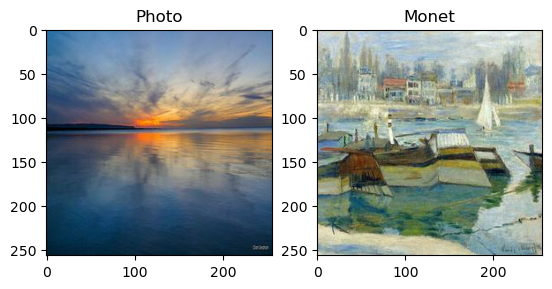

In [10]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Building the Generator 


### Defining the Downsampling Block


The CycleGAN Generator model takes an input image and generates an output image. To achieve this, the model architecture begins with a sequence of **downsampling convolutional blocks** (reduce the 2D dimensions, width and height of an image by the stride) to encode the input image. 

To define a downsampling block, we will use the instance normalization method instead of batch normalization as our batch size is very small. **InstanceNorm transforms each training sample independently over multiple channels, whereas BatchNorm does that to the whole batch of samples over each channel**. The intent is to remove image-specific contrast information from the image, which simplifies the generation and results in better generated images.


As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.


In [11]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

The defined downsampling block provides an efficient way for us to add multiple **Convolution-InstanceNorm-LeakyReLU** layers with variable number of filters and filter sizes.


### Defining the Upsampling Block


Next, the Generator uses a number of **Upsampling blocks** to generate the output image. 

Upsampling does the opposite of downsampling and increases the dimensions of the image. Hence, we use the `Conv2DTranspose` API from keras to create **TransposeConvolution-InstanceNorm-ReLU** layers to build the block.


In [12]:
def upsample(filters, size, apply_dropout=False):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### Assembling the Generator


The Generator uses a sequence of **downsampling convolutional blocks** to encode the input image, a number of **residual network (ResNet) convolutional blocks** to transform the image, and a number of **upsampling convolutional blocks** to generate the output image.

The ResNet blocks essentially **skip connections to help bypass the vanishing gradient problem** through concatenating the output of downsampling layers directly to the output of upsampling layers. You will see that we concatenate them in a symmetrical fashion in the following code cell.


In [13]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

Let's visualize our Generator model's architecture using the `plot_model` function from `keras.utils.vis_untils`.


In [14]:
gen = Generator()
plot_model(gen, show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


By looking at the visualization, we can see very clealy how the skip connections operation works and that all the concatenations are done symmetrically.

## Building the Discriminator


The discriminator model takes a $256 \times 256$ color image and is responsible for classifying it as real or fake. "Fake" as in being produced by the Generator. 

This can be implemented directly by borrowing the architecture of a somewhat standard deep convolutional discriminator model. Thus, it can be built by mainly using the **Convolution-InstanceNorm-LeakyReLU** layers. 

Although the InstanceNorm method was designed for generator models, it can also prove effective in discriminator models. 

Our Discriminator model will be built using 4 Convolution-InstanceNorm-LeakyReLU layers with 64, 128, 256, and 512 sized 4 filters, respectively. After the last layer, we apply a convolution to produce a 1-dimensional output.


In [15]:
def Discriminator():

    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

Similarly, we can visualize the architecture of the Discriminator model:


In [16]:
disc = Discriminator()
plot_model(disc, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


The discrimiator model looks much less complicated than the generator as it's mainly doing downsampling. But still, if you run `disc.summary()`, we will notice that it has 2M parameters to train, which is not an easy task either.

Now that we have the generator and discriminator network ready, it's time to build our mighty CycleGAN model!


## Building the CycleGAN Model


In order to ensure that the mapping between images from two domains is meaningful and desirable, we enforce forward-backward consistency by involving two mappings: $\boldsymbol G: X \rightarrow Y$ and the inverse $\boldsymbol F: Y \rightarrow X$.

This means, our CycleGAN model needs two generators. One for transforming photos to Monet-esque paintings and one for transforming Monet paintings to be more like photos.

Since we have two generators, we would naturally need two discriminators to "discriminate" the work of each of them. This leads to our definition of `monet_generator`, `photo_generator`, `monet_discriminator`, and `photo_discriminator` in the next cell.


In [17]:
with strategy.scope():
    
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

All 4 networks that we defined here will be used to compile a CycleGAN.


In the next cell, we create the CycleGAN class.

- The `CycleGan` class subclasses `tf.keras.Model` so that it retains all the methods of keras models such as the `.fit()` method.
- A CycleGan model will compile with 4 optimizers and 4 loss functions, each optimizer is associated with a network.
- During a `train_step`, the CycleGan model transforms a real photo to a Monet painting and then back to a photo, a real Monet painting to a photo and then back to Monet painting.
- The cycle consistency loss is calculated as the sum of the absolute differences between the two real images and their corresponding cycled images.


In [18]:
class CycleGan(keras.Model):
    
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
        
    @tf.function
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Defining Loss Functions


A perfect discriminator shoud output all 1s for a real image and all 0s for a fake image. Hence, the `discriminator_loss` compares the discriminator's prediction for a real image to a matrix of 1s and the prediction for a fake image to a matrix of 0s. The differences are quantified using Binary Cross Entropy.

The [CycleGAN paper](https://arxiv.org/abs/1703.10593?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0KSEEN39299759-2022-01-01) suggests dividing the loss for the discriminator by half during training, in an effort to slow down updates to the discriminator relative to the generator.


In [19]:
with strategy.scope():
    
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

A perfect generator should fool the discriminator by generating images that the discriminator predicts as real or all 1s. Thus, the `generator_loss` compares the discriminator's prediction for a generated image to a matrix of 1s.


In [20]:
with strategy.scope():
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                    reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

Here is the `calc_cycle_loss`, or the Cycle Consistency Loss, which is the average of the absolute differences between a real image and a cycled (twice transformed) image.


In [21]:
#We want our original photo and the twice transformed photo to be similar to one another. 
#Thus, we can calculate the cycle consistency loss be finding the average of their difference.

with strategy.scope():
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

Lastly, we have the `identity_loss`. It penalizes large difference between a real image and an image generated by the Generator based on the real image, as a perfect Generator should not have disparate input and output.


In [22]:
with strategy.scope():
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Model Training


In this section, we will compile and train a CycleGAN. Since our networks have too many parameters (one generator alone has 54M and a discriminator has 2M) and Skills Network Labs currently doesn't have any GPUs available, it will take hours to train a sufficient number of epochs with a CPU such that the model can do a decent job in transfering image styles.

Therefore, we will train the model for **one epoch** in this lab, which includes 300 iterations.

### Training the CycleGAN


As I mentiond before, a CycleGAN is compiled with 4 loss functions and 4 optimizers. Let's define the optimizer for each network and then compile the model.


In [23]:
with strategy.scope():
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
with strategy.scope():
    
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [25]:
#history = cycle_gan_model.fit(
#    tf.data.Dataset.zip((monet_ds, photo_ds)),
#    epochs=1)

## Visualize our Monet-esque photos


### Loading Pre-trained Weights


This is a screenshot of the CycleGAN's training history. Even though only the monet generator is needed for the style transfer task, but we can see that the losses of all 4 networks: monet generator, monet discriminator, photo generator, and photo discriminated, were being optimized. 


<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0KSEEN/images/training_history.png" style="vertical-align:middle;margin:20px 0px"></center>


Downloading the weights of `monet_generator`:


In [26]:
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/LargeData/monet_generator_50_epochs.tgz",
                           overwrite=True)

  0%|          | 0/14 [00:00<?, ?it/s]

Saved to '.'


Creating the `monet_generator_model` using the `load_model` API from Keras:


In [27]:
monet_generator_model = tf.keras.models.load_model("monet_generator_50_epochs")

### Visualizing Style Transfer Output


Finally! We will visualize the style transfer output produced by `monet_generator_model`. We take 5 sample images that are photos of beautiful landscapes in the original dataset and feed them to the model. 


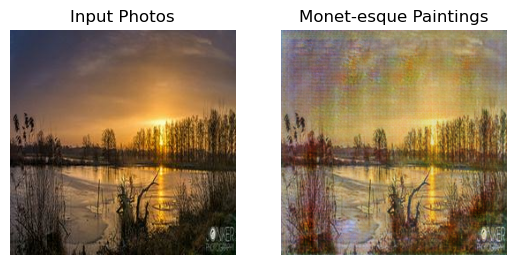

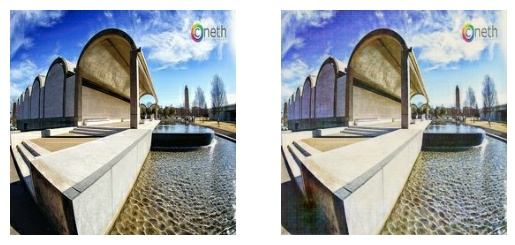

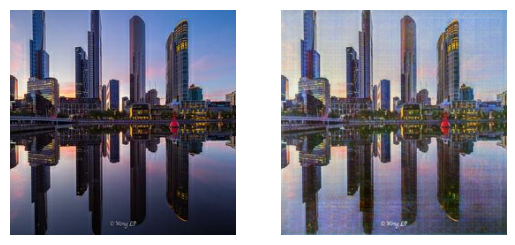

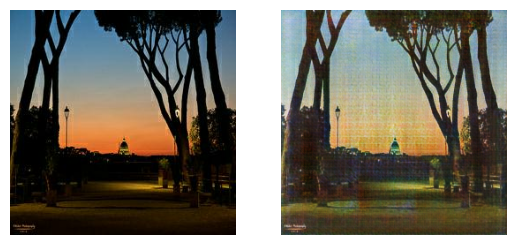

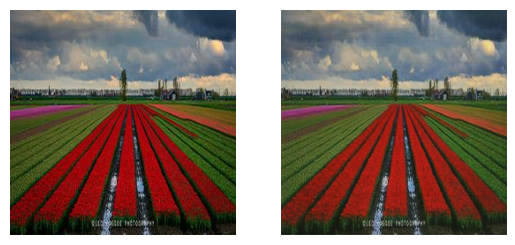

In [28]:
for i in range(5):
    
    # randomly draw a photo from PHOTO_FILENAMES
    rand_ind = random.randint(0,299)
    img_path = PHOTO_FILENAMES[rand_ind]
    img = decode_image(img_path)
    img = tf.expand_dims(img, axis=0)
    
    prediction = monet_generator_model(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    fig = plt.figure()
    fig.add_subplot(1,2,1)
    if i == 0:
        plt.title("Input Photos")
    plt.imshow(img)
    plt.axis("off")
    
    fig.add_subplot(1,2,2)
    if i == 0:
        plt.title("Monet-esque Paintings")
    plt.imshow(prediction)
    plt.axis("off")